In [53]:
# prints some diagnostic information on the current colab runtime
!nvidia-smi

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

/bin/bash: nvidia-smi: command not found
Your runtime has 13.6 gigabytes of available RAM



In [54]:
import warnings
#warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.io import loadmat
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
import random
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import activations
from tensorflow.keras import losses
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

!pip install keras-tuner --upgrade 
import keras_tuner
import time
from IPython.display import display, Markdown
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
files = glob.glob('drive/My Drive/training2017/A0[0-9][0-9][0-9][0-9].mat', recursive = True)
mat_list = []
for file in files:
    mat = loadmat(file)
    mat_list.append(mat)

In [55]:
labels = pd.read_csv('drive/My Drive/training2017/REFERENCE.csv', header=None, index_col=False,)

In [56]:
ecg_list = []
for mat in mat_list:
    dum = mat['val'].reshape((-1))
    ecg_list.append(dum)

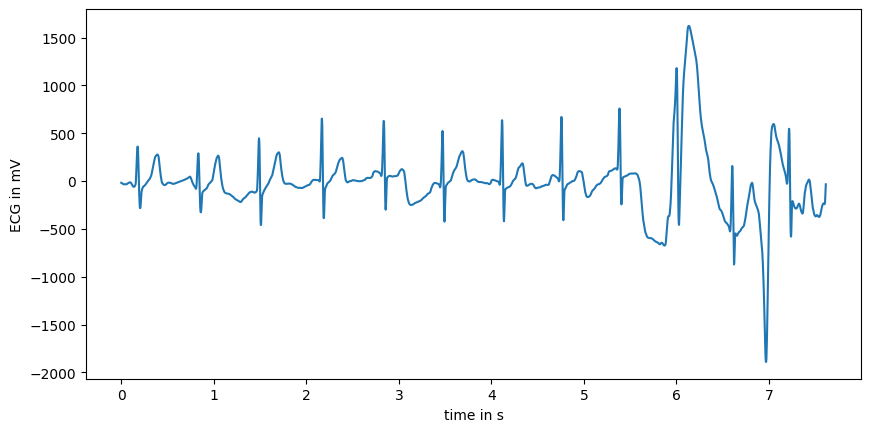

In [57]:
f = plt.figure()
f.set_figwidth(10)
fs = 360

ecg = random.choice(ecg_list)

time = np.arange(ecg.size) / fs
plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.show()

<Axes: xlabel='1', ylabel='count'>

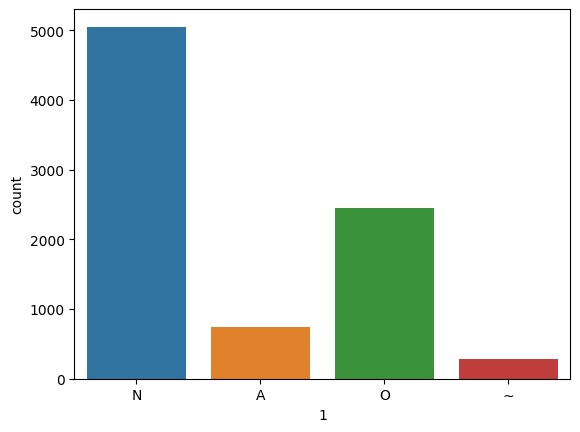

In [58]:
sns.countplot(x = labels[1])

In [29]:
print("ecg list length: ", len(min(ecg_list, key = len)))
print("ecg length: " , len(ecg_list[0]))

ecg list length:  2714
ecg length:  9000


# Change all the ecg's to the shortest length 
issues that could happen: maybe too short and lead to incorrect classification because irregularity might happen later in the ecg


In [59]:
modified_ecg = []

for ecg in ecg_list:
    dum = ecg[:2714]
    modified_ecg.append(dum)

In [60]:
len(modified_ecg[0])

2714

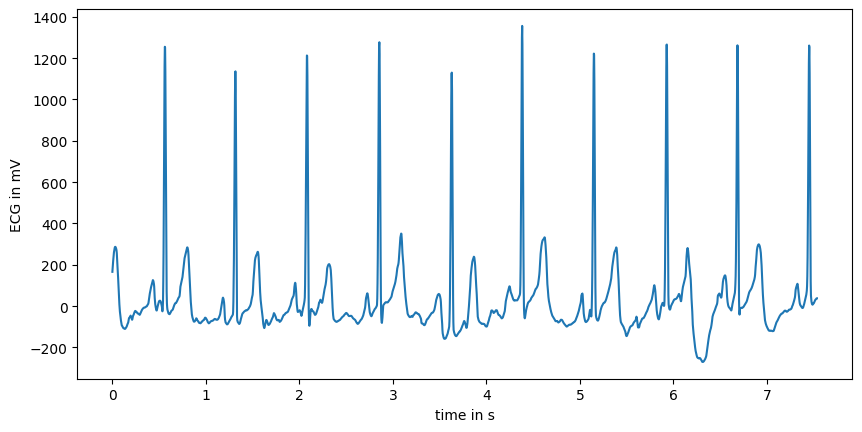

In [61]:
f = plt.figure()
f.set_figwidth(10)
fs = 360

ecg = random.choice(modified_ecg)

time = np.arange(ecg.size) / fs
plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.show()

# Reading the Labels and Test/Train Split


In [62]:
labels = pd.read_csv('drive/My Drive/training2017/REFERENCE.csv', header=None, index_col=False,)
labels.reset_index()
labels = labels.drop(0, axis = 1)

df = pd.DataFrame()

conditions = [
    (labels[1] == 'N'),
    (labels[1] == 'A'),
    (labels[1] == 'O'),
    (labels[1] == '~')
]
values = [0, 1, 2, 3]

df['labels'] = np.select(conditions, values)
df.to_numpy()

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [63]:
x_train, x_test, y_train, y_test = train_test_split(modified_ecg, df, test_size=0.25, random_state=42)
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

In [64]:
new_x_train = np.expand_dims(np.random.normal(size= (6396, 2714)), axis = -1)
new_x_test = np.expand_dims(np.random.normal(size= (6396, 2714)), axis = -1)

In [65]:
new_x_train = np.reshape(a = x_train, newshape = ((6396, 2714, 1)))
new_x_test = np.reshape(a = x_test, newshape = ((2132, 2714, 1)))

#Making the Model

In [205]:
model = keras.Sequential()
model.add(layers.Flatten())
model.add(
    layers.Dense(
        # Tune number of units.
        units = 928,
        # Tune the activation function to use.
        activation = 'relu'
    )
)

# Tune whether to use dropout
model.add(layers.Dropout(rate=0.25))

model.add(layers.Dense(10, activation="softmax"))

# Define the optimizer learning rate as a hyperparameter.
learning_rate = 0.007537119294169523
model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

In [209]:
# FITTING
history = model.fit(x = x_train, y = y_train, batch_size = 128, steps_per_epoch = None, epochs=30, verbose = 0)
avg_acc = 0
avg_loss = 0
for i, k in zip(history.history['loss'], history.history['accuracy']):
    avg_loss = i + avg_loss
    avg_acc = k + avg_acc

print("Training Info")
print('avg_loss = ', avg_loss / len(history.history['loss']))
print('avg_acc = ', avg_acc / len(history.history['accuracy']))
print("min loss: ", min(history.history['loss']))
print("max acc: ", max(history.history['accuracy']))
print("\n")

# PREDICTING
results = model.evaluate(x_train, y_train, batch_size = 128, steps = 1)
predictions = model.predict(x_test, steps = 1)
print("predictions shape:", predictions.shape)
new_pred = []
pred = predictions.tolist()
for i in pred:
    new_pred.append(i.index(max(i)))

print("Evalution Info")
print("Accuracy Score: ", accuracy_score(new_pred, y_test))
print("Confusion Matrix: \n", confusion_matrix(new_pred, y_test))

Training Info
avg_loss =  38.60209331512451
avg_acc =  0.922357726097107
min loss:  27.783973693847656
max acc:  0.942307710647583


1/1 [==============================] - 0s 218ms/step
predictions shape: (2132, 10)
Evalution Info
Accuracy Score:  0.5060975609756098
Confusion Matrix: 
 [[935 117 431  46]
 [ 78  14  33   2]
 [270  47 128  14]
 [  9   2   4   2]]


# Optimizing DNN Model

In [199]:
def build_DNN_model(hp):
    #optimizer = SGD(learning_rate=0.01)
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=1024, step=32),
            # Tune the activation function to use.
            activation='relu'
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="softmax"))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

build_DNN_model(keras_tuner.HyperParameters())

hp = keras_tuner.HyperParameters()

tuner = keras_tuner.RandomSearch(
    hypermodel = build_DNN_model,
    objective = "val_accuracy",
    executions_per_trial = 2,
    overwrite=True,
)

tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
tuner.results_summary()

Trial 10 Complete [00h 01m 25s]
val_accuracy: 0.5553471148014069

Best val_accuracy So Far: 0.5553471148014069
Total elapsed time: 00h 10m 46s
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
units: 672
dropout: True
lr: 0.004561896914979461
Score: 0.5553471148014069

Trial 03 summary
Hyperparameters:
units: 928
dropout: True
lr: 0.007537119294169523
Score: 0.5391651093959808

Trial 04 summary
Hyperparameters:
units: 960
dropout: True
lr: 0.0011916880323429942
Score: 0.5250938087701797

Trial 08 summary
Hyperparameters:
units: 448
dropout: False
lr: 0.0013201307778650327
Score: 0.5229831039905548

Trial 00 summary
Hyperparameters:
units: 832
dropout: True
lr: 0.0005181886188307158
Score: 0.5117260813713074

Trial 05 summary
Hyperparameters:
units: 224
dropout: True
lr: 0.0003302984517264682
Score: 0.48311443626880646

Trial 02 summary
Hyperparameters:
units: 448
dropout: False
lr: 0.0

#Hypertuning CNN Model (FAILURE)
While trying to find a way to hypertune this cnn model, I ran into multiple issues that prevented me from doing so 
That ranged from not understanding CNN structures to a literal bug in the libaray itself that wasted about 9 hours of my life, and so I've decided to abandon optimizing the CNN 

In [183]:
def build_CNN_model(hp):
    #optimizer = SGD(learning_rate=0.01)
    model = keras.Sequential()
    #model.add(layers.Flatten())
    model.add(
        layers.Conv1D(
            filters = hp.Int('conv_1_filter', min_value = 32, max_value = 128, step = 16),
            kernel_size = hp.Choice('conv_1_kernel', values = [3, 5]),
            activation = 'relu',
            input_shape = new_x_train.shape
            #1, (1), activation='relu', input_shape=new_x_train[0].shape
            )
        )
    
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=1024, step=32),
            # Tune the activation function to use.
            activation='relu',
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="softmax"))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

build_CNN_model(keras_tuner.HyperParameters())

hp = keras_tuner.HyperParameters()

tuner = keras_tuner.RandomSearch(
    hypermodel = build_CNN_model,
    objective = "val_accuracy",
    executions_per_trial = 2,
    overwrite=True,
)
tuner.search(new_x_train, y_train, epochs=5, validation_data=(x_test, y_test))

#CNN Model

In [223]:
model = models.Sequential()
model.add(layers.Conv1D(32, (3), activation='relu', input_shape=new_x_train[0].shape))

model.add(tf.keras.layers.GlobalAveragePooling1D())

model.add(
    layers.Dense(
        # Tune number of units.
        units = 672,
        # Tune the activation function to use.
        activation = 'relu'
    )
)
model.add(
    layers.Dense(
        # Tune number of units.
        units = 672,
        # Tune the activation function to use.
        activation = 'relu'
    )
)

model.add(layers.Dense(10, activation=tf.keras.activations.softmax))
model.compile(loss='sparse_categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 2712, 32)          128       
                                                                 
 global_average_pooling1d_9   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_24 (Dense)            (None, 672)               22176     
                                                                 
 dense_25 (Dense)            (None, 672)               452256    
                                                                 
 dense_26 (Dense)            (None, 10)                6730      
                                                                 
Total params: 481,290
Trainable params: 481,290
Non-trainable params: 0
_______________________________________________

In [224]:
# FITTING
history = model.fit(x = x_train, y = y_train, batch_size = 128, steps_per_epoch = None, epochs=30, verbose = 0)
avg_acc = 0
avg_loss = 0
for i, k in zip(history.history['loss'], history.history['accuracy']):
    avg_loss = i + avg_loss
    avg_acc = k + avg_acc

print("Training Info")
print('avg_loss = ', avg_loss / len(history.history['loss']))
print('avg_acc = ', avg_acc / len(history.history['accuracy']))
print("min loss: ", min(history.history['loss']))
print("max acc: ", max(history.history['accuracy']))
print("\n")

# PREDICTING
results = model.evaluate(x_train, y_train, batch_size = 128, steps = 1)
predictions = model.predict(x_test, steps = 1)
print("predictions shape:", predictions.shape)
new_pred = []
pred = predictions.tolist()
for i in pred:
    new_pred.append(i.index(max(i)))

print("Evalution Info")
print("Accuracy Score: ", accuracy_score(new_pred, y_test))
print("Confusion Matrix: \n", confusion_matrix(new_pred, y_test))

Training Info
avg_loss =  1.0905574560165405
avg_acc =  0.5802011648813884
min loss:  1.0225754976272583
max acc:  0.5872420072555542


1/1 [==============================] - 1s 1s/step
predictions shape: (2132, 10)
Evalution Info
Accuracy Score:  0.5919324577861164
Confusion Matrix: 
 [[1225  169  559   61]
 [   0    0    0    0]
 [  67   11   37    3]
 [   0    0    0    0]]


In [226]:
model = models.Sequential()
model.add(tf.keras.layers.LSTM(4, input_shape = new_x_train[0].shape, 
                    activation='relu'))

model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(units=10, activation=tf.keras.activations.softmax))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

#model = create_RNN(2, 1, (3,1), activation=['linear', 'linear'])

In [227]:
# FITTING
history = model.fit(x = new_x_train, y = y_train, batch_size = 128, steps_per_epoch = None, epochs=10, verbose = 0)
avg_acc = 0
avg_loss = 0
for i in history.history['loss']:
    avg_loss = i + avg_loss
    #avg_acc = k + avg_acc

print("Training Info")
print('avg_loss = ', avg_loss / len(history.history['loss']))
#print('avg_acc = ', avg_acc / len(history.history['acc']))
print("min loss: ", min(history.history['loss']))
#print("max acc: ", max(history.history['acc']))
print("\n")

# PREDICTING
results = model.evaluate(new_x_test, y_test, batch_size = 128, steps = 1)
predictions = model.predict(new_x_test, steps = 1)
print("predictions shape:", predictions.shape)
new_pred = []
pred = predictions.tolist()
for i in pred:
    new_pred.append(i.index(max(i)))

print("Evalution Info")
print("Accuracy Score: ", accuracy_score(new_pred, y_test))
print("Confusion Matrix: \n", confusion_matrix(new_pred, y_test))

Training Info
avg_loss =  nan
min loss:  nan


1/1 [==============================] - 1s 1s/step
predictions shape: (2132, 10)
Evalution Info
Accuracy Score:  0.6060037523452158
Confusion Matrix: 
 [[1292  180  596   64]
 [   0    0    0    0]
 [   0    0    0    0]
 [   0    0    0    0]]
